In [4]:
!pip install coremltools


     |████████████████████████████████| 3.4MB 7.0MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=a168a010f1be2ae8745e31abd2cd1ef871598c3b48661da015a28bab53f5e32e
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import LayerNormalization
from keras.layers import Dropout
from keras.models import load_model
from keras.backend import clear_session
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import gc
from sklearn.metrics import confusion_matrix
import coremltools

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [6]:
plt.rcParams["figure.figsize"] = (15,10)


## Test different window and stride sizes

In [6]:
def train_model(X_filepath, y_filepath, epochs, learning_rate, batch_size):
  X = np.load(X_filepath,allow_pickle=True)
  y = np.load(y_filepath, allow_pickle=True)

  r = np.random.permutation(len(X))
  X = X[r]
  y = y[r]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  weight_for_0 = (1 / (len(y_train)-sum(y_train))) * (len(y_train) / 2.0)
  weight_for_1 = (1 / sum(y_train)) * (len(y_train) / 2.0)
  class_weight = {0:weight_for_0,1:weight_for_1}
  #Model

  model = Sequential()
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/2), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1 , center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/4), return_sequences=True,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Bidirectional(LSTM(int(X.shape[1]/8), return_sequences=False,stateful=False)))
  model.add(Dropout(.2))
  model.add(LayerNormalization(axis=-1, center=True , scale=True))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
  # train LSTM
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_split=.1, class_weight=class_weight)
  # evaluate LSTM
  
  yhat = model.predict(X_test, verbose=2)
  metrics = model.evaluate(X_test,y_test)
  model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_'+X_filepath[88:-9])
  
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.legend()
  plt.title('Training and Validation Loss over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_loss')
  plt.show()
  
  plt.plot(history.history['accuracy'],label = 'Training Accuracy')
  plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_acc')
  plt.show()
  
  plt.plot(history.history['auc'],label = 'Training AUC_ROC')
  plt.plot(history.history['val_auc'], label = 'Validation AUC_ROC')
  plt.legend()
  plt.title('Training and Validation AUC_ROC over '+str(epochs)+ ' Epochs '+X_filepath[88:-9])
  plt.savefig('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Loss_and_Accuracy_Plots/model_'+X_filepath[88:-4]+'_auc')
  plt.show()
  del X
  del y
  clear_session()
  gc.collect()
  return metrics

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/300
276/276 - 116s - loss: 0.5456 - accuracy: 0.7099 - auc: 0.7867 - val_loss: 0.5665 - val_accuracy: 0.7064 - val_auc: 0.7910
Epoch 2/300
276/276 - 73s - loss: 0.5151 - accuracy: 0.7192 - auc: 0.8046 - val_loss: 0.5376 - val_accuracy: 0.7143 - val_auc: 0.8049
Epoch 3/300
276/276 - 73s - loss: 0.5131 - accuracy: 0.7199 - auc: 0.8067 - val_loss: 0.5844 - val_accuracy: 0.7023 - val_auc: 0.8019
Epoch 4/300
276/276 - 73s - loss: 0.5035 - accuracy: 0.7236 - auc: 0.8139 - val_loss: 0.5234 - val_accuracy: 0.7133 - val_auc: 0.8148
Epoch 5/300
276/276 - 73s - loss: 0.5370 - accuracy: 0.7052 - auc: 0.7868 - val_loss: 0.5953 - val_accuracy: 0.6941 - val_auc: 0.7756
Epoch 6/300
276/276 - 73s - loss: 0.5397 - accuracy: 0.6979 - auc: 0.7808 - val_loss: 0.5556 - val_accuracy: 0.6788 - val_auc: 0.7789
Epoch 7/300
276/276 - 73s - loss: 0.5300 - accuracy: 0.70

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_2500/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_2500/assets


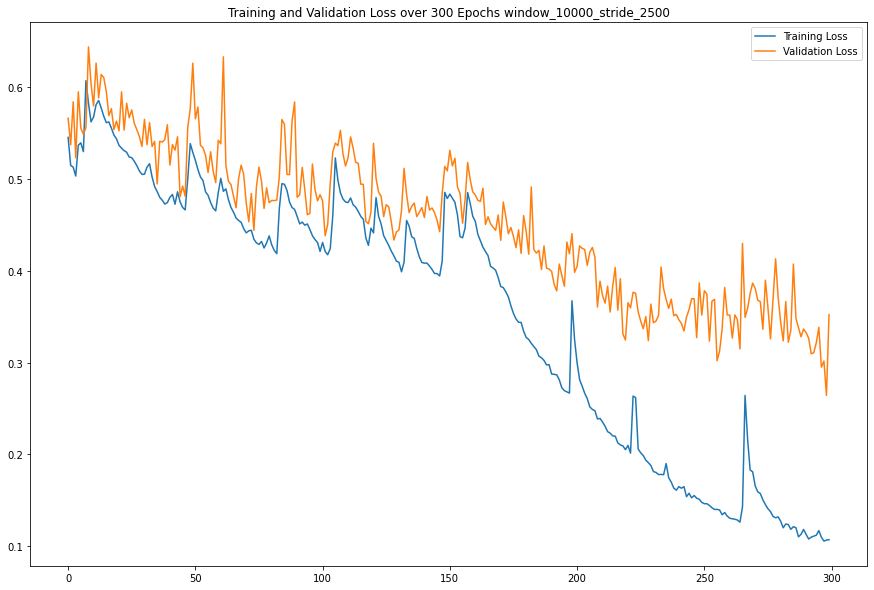

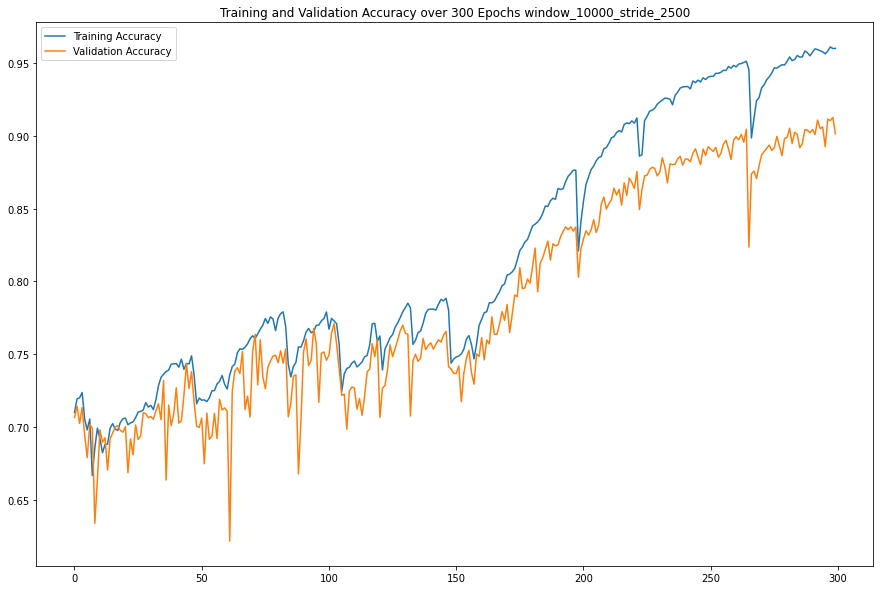

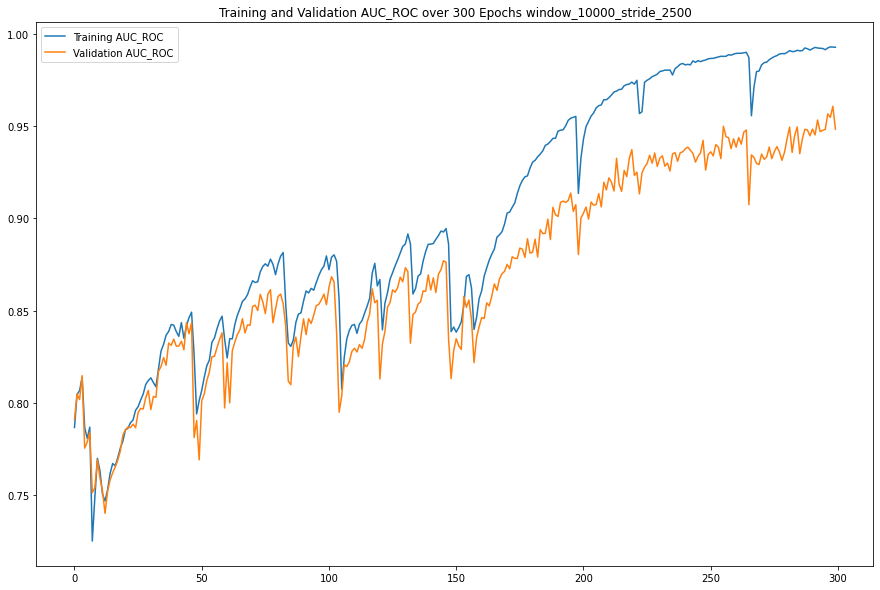

Epoch 1/300
138/138 - 47s - loss: 0.5820 - accuracy: 0.6990 - auc: 0.7652 - val_loss: 0.5593 - val_accuracy: 0.7102 - val_auc: 0.7891
Epoch 2/300
138/138 - 32s - loss: 0.5335 - accuracy: 0.7155 - auc: 0.7950 - val_loss: 0.5271 - val_accuracy: 0.7148 - val_auc: 0.7949
Epoch 3/300
138/138 - 32s - loss: 0.5251 - accuracy: 0.7150 - auc: 0.7984 - val_loss: 0.5262 - val_accuracy: 0.7166 - val_auc: 0.8059
Epoch 4/300
138/138 - 32s - loss: 0.5133 - accuracy: 0.7200 - auc: 0.8059 - val_loss: 0.5303 - val_accuracy: 0.7181 - val_auc: 0.7945
Epoch 5/300
138/138 - 32s - loss: 0.5135 - accuracy: 0.7253 - auc: 0.8070 - val_loss: 0.5902 - val_accuracy: 0.6542 - val_auc: 0.7921
Epoch 6/300
138/138 - 32s - loss: 0.5117 - accuracy: 0.7184 - auc: 0.8088 - val_loss: 0.5418 - val_accuracy: 0.7159 - val_auc: 0.8059
Epoch 7/300
138/138 - 32s - loss: 0.5066 - accuracy: 0.7201 - auc: 0.8106 - val_loss: 0.5564 - val_accuracy: 0.7006 - val_auc: 0.7940
Epoch 8/300
138/138 - 32s - loss: 0.5257 - accuracy: 0.7149 - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_5000/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_5000/assets


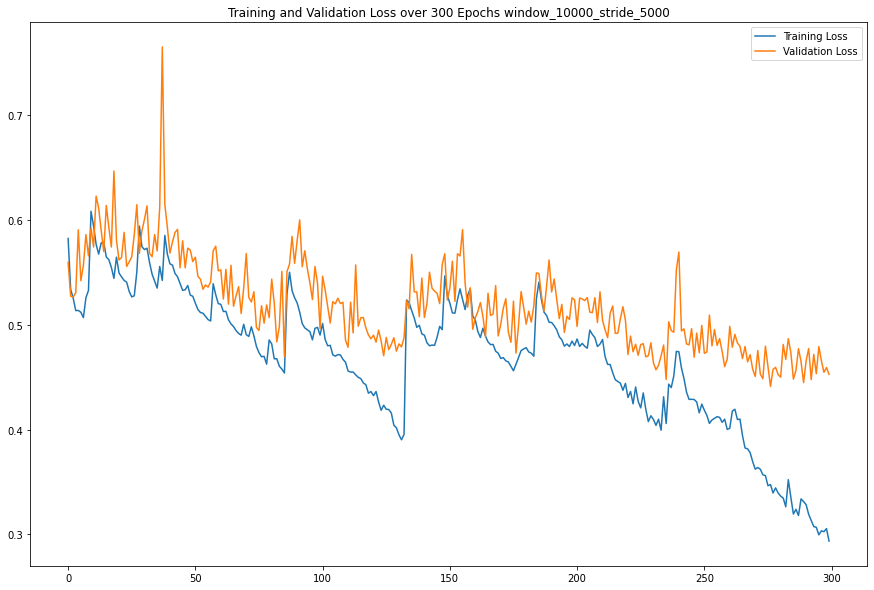

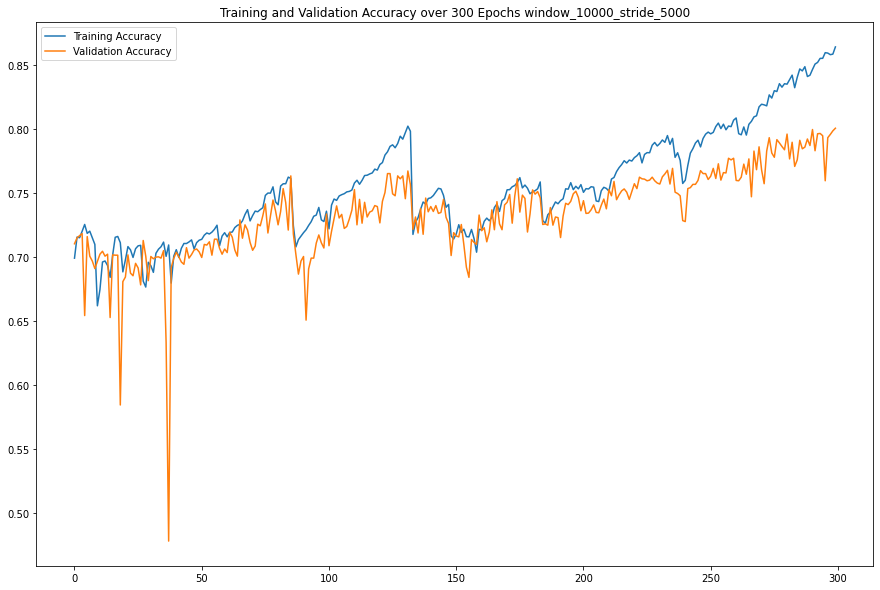

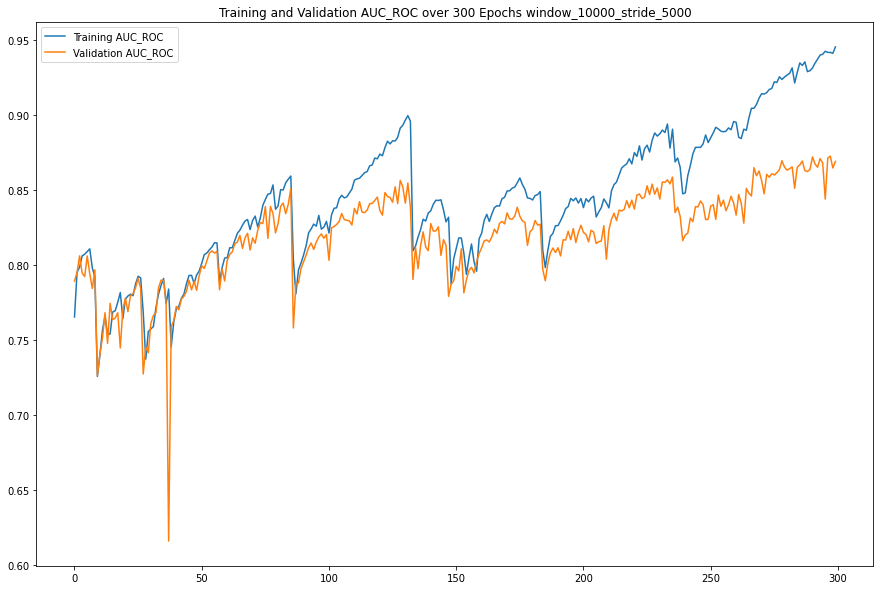

,Window Size,Stride Size,Acc,AUC ROC,Loss
0,10000,2500,0.910268,0.954960,0.317534
1,10000,5000,0.803167,0.865134,0.458056


In [7]:
Y_filepath = [f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets', f))][4:]
X_filepath = [f for f in listdir('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets') if isfile(join('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets', f))][4:]
loss = []
auc = []
acc = []
window = []
stride = []
for X,y in zip(X_filepath,Y_filepath):
  metrics = train_model('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets/'+X,'/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets/'+y, 300,1e-3,256)
  loss.append(metrics[0])
  acc.append(metrics[1])
  auc.append(metrics[2])
  window.append(X.split('_')[2])
  stride.append(X.split('_')[4])
metric_df = pd.DataFrame({'Window Size':window, 'Stride Size': stride, 'Acc': acc,'AUC ROC':auc, 'Loss':loss})
metric_df.to_csv('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/window_and_stride_comp.csv')
metric_df

## Original model building


In [ ]:
r = np.random.permutation(len(X))
X = X[r]
y = y[r]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
weight_for_0 = (1 / (len(y_train)-sum(y_train))) * (len(y_train) / 2.0)
weight_for_1 = (1 / sum(y_train)) * (len(y_train) / 2.0)
class_weight = {0:weight_for_0,1:weight_for_1}

In [ ]:
#Model

model = Sequential()

model.add(LayerNormalization(axis=-1 , center=True , scale=True))
model.add(Bidirectional(LSTM(100, return_sequences=True,stateful=False)))

model.add(Dropout(.2))
model.add(LayerNormalization(axis=-1 , center=True , scale=True))
model.add(Bidirectional(LSTM(50, return_sequences=True,stateful=False)))
model.add(Dropout(.2))

model.add(LayerNormalization(axis=-1, center=True , scale=True))
model.add(Bidirectional(LSTM(25, return_sequences=False,stateful=False)))
model.add(Dropout(.2))

model.add(LayerNormalization(axis=-1, center=True , scale=True))


model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
# train LSTM
history = model.fit(X_train, y_train, epochs=300, batch_size=256, verbose=2,validation_split=.1, class_weight=class_weight)
# evaluate LSTM
yhat = model.predict(X_test, verbose=2)
model.evaluate(X_test,y_test)


Epoch 1/300
276/276 - 60s - loss: 0.5532 - accuracy: 0.7070 - auc: 0.7816 - val_loss: 0.5686 - val_accuracy: 0.7110 - val_auc: 0.8083
Epoch 2/300
276/276 - 47s - loss: 0.5168 - accuracy: 0.7177 - auc: 0.8047 - val_loss: 0.5208 - val_accuracy: 0.7293 - val_auc: 0.8028
Epoch 3/300
276/276 - 46s - loss: 0.5178 - accuracy: 0.7160 - auc: 0.8037 - val_loss: 0.4932 - val_accuracy: 0.7334 - val_auc: 0.8183
Epoch 4/300
276/276 - 47s - loss: 0.5101 - accuracy: 0.7168 - auc: 0.8083 - val_loss: 0.5398 - val_accuracy: 0.7207 - val_auc: 0.8086
Epoch 5/300
276/276 - 46s - loss: 0.5058 - accuracy: 0.7209 - auc: 0.8099 - val_loss: 0.5165 - val_accuracy: 0.7329 - val_auc: 0.8267
Epoch 6/300
276/276 - 46s - loss: 0.4968 - accuracy: 0.7272 - auc: 0.8195 - val_loss: 0.5211 - val_accuracy: 0.7288 - val_auc: 0.8267
Epoch 7/300
276/276 - 47s - loss: 0.5009 - accuracy: 0.7197 - auc: 0.8189 - val_loss: 0.5708 - val_accuracy: 0.6892 - val_auc: 0.8028
Epoch 8/300
276/276 - 46s - loss: 0.4984 - accuracy: 0.7270 - 

[0.1669636368751526, 0.9575294852256775, 0.9825380444526672]

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project EDA/Model Saves/model_100_50_25/assets


## Load best performing window and stride size

In [5]:
model = load_model('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000')


In [10]:
X = np.load('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/X_Datasets/X_window_10000_stride_1000_data.npy', allow_pickle = True)
y = np.load('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection/Datasets/Y_Datasets/Y_window_10000_stride_1000_data.npy', allow_pickle = True)

In [11]:
r = np.random.permutation(len(X))
X = X[r]
y = y[r]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
yhat = model.predict(X_test, verbose=2)
yhat

3017/3017 - 145s


array([[2.0659280e-01],
       [9.9999547e-01],
       [2.0044395e-01],
       ...,
       [1.4816530e-04],
       [7.2334046e-08],
       [1.1389410e-06]], dtype=float32)

In [27]:
#Confusion matrix
confusion_matrix(y_test,np.array(yhat.flatten()>.5, dtype=int), normalize = 'true')


array([[0.98999706, 0.01000294],
       [0.04236991, 0.95763009]])

## Port Keras model to CoreML model

In [10]:
model.save('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000.h5')

In [30]:
model

In [9]:
converter = coremltools.converters.keras.convert('/content/drive/MyDrive/Capstone Project EDA/Model Saves/model_window_10000_stride_1000')
tflite_model = converter.convert()
open('/content/drive/MyDrive/Capstone Project EDA/inebriation_detection', "wb").write(tflite_model)

ValueError: ignored